# Download TF Model Garden

In [ ]:
# Clone into the TensorFlow Models directory on Github
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3424, done.
remote: Counting objects: 100% (3424/3424), done.
remote: Compressing objects: 100% (2859/2859), done.
remote: Total 3424 (delta 895), reused 1433 (delta 508), pack-reused 0
Receiving objects: 100% (3424/3424), 35.12 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (895/895), done.


# Install Protobufs

The Tensorflow Object Detection API uses Protobufs to configure model and train parameters. 

In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

# Install TF Object Detection API

In [ ]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 7.8 MB/s 
     |████████████████████████████████| 352 kB 64.9 MB/s 
     |████████████████████████████████| 2.1 MB 40.4 MB/s 
     |████████████████████████████████| 25.9 MB 98.1 MB/s 
     |████████████████████████████████| 67 kB 8.7 MB/s 
     |████████████████████████████████| 48.3 MB 88 kB/s 
     |████████████████████████████████| 636 kB 71.6 MB/s 
     |████████████████████████████████| 1.2 MB 51.7 MB/s 
     |█

# Test Installation

In [ ]:
!cd /content/models/research && \
python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-07-20 01:32:49.365496: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0720 01:32:49.719437 140473086510976 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.59s
I0720 01:32:49.973500 140473086510976 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.59s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.51s
I0720 01:32:50.487964 140473086510976 test_u

# Download the Pre-trained Model

In [ ]:
# Download the pre-trained model (ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8)
!cd /content/Application/workspace/pretrained_model && \
wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz && \
tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2022-07-14 03:25:21--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.4.128, 2404:6800:4003:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.4.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  12.9MB/s    in 1.5s    

2022-07-14 03:25:23 (12.9 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



# Import Dependencies

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util
from object_detection.builders import model_builder

# Setting up Paths

In [ ]:
ANNOTATION_PATH = "/content/Application/workspace/annotations"
LABEL_MAP_PATH = os.path.join(ANNOTATION_PATH, "labelmap.pbtxt")
GENERATE_TF_RECORD_SCRIPT = "/content/Application/scripts/generate_tfrecord.py"
IMAGE_PATH = "/content/Application/workspace/images"

# Prepare Data For Training

## Create Label Map

In [ ]:
category_labels = [{'name': "Yes",      'id': 1},
                   {'name': "No",       'id': 2},
                   {'name': "iLoveYou", 'id': 3},
                   {'name': "Hello",    'id': 4},
                   {'name': "ThankYou", 'id': 5}]

category_labels

[{'id': 1, 'name': 'Yes'},
 {'id': 2, 'name': 'No'},
 {'id': 3, 'name': 'iLoveYou'},
 {'id': 4, 'name': 'Hello'},
 {'id': 5, 'name': 'ThankYou'}]

In [ ]:
# Storing category labels in standard format .pbtxt format
with open(LABEL_MAP_PATH, "w") as f:
  for label in category_labels:
    f.write('item { \n')
    f.write('\tname:\'{}\'\n'.format(label['name']))
    f.write('\tid:{}\n'.format(label['id']))
    f.write('}\n')

## Create TF Records
We need to convert our annotations into **TFRecord** format. TFRecord is a special file format that the TFOD API uses.

In [ ]:
# For training images
!python {GENERATE_TF_RECORD_SCRIPT} -x {IMAGE_PATH + "/train"} -l {LABEL_MAP_PATH} -o {ANNOTATION_PATH + "/train.record"} 

# For testing images
!python {GENERATE_TF_RECORD_SCRIPT} -x {IMAGE_PATH + "/test"} -l {LABEL_MAP_PATH} -o {ANNOTATION_PATH + "/test.record"} 

Successfully created the TFRecord file: /content/Application/workspace/annotations/train.record
Successfully created the TFRecord file: /content/Application/workspace/annotations/test.record


## Update the Model Based on the Data

In [ ]:
NUM_CLASSES = 5
BATCH_SIZE = 4

CONFIG_PATH = "/content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config"

CHECKPOINT_PATH = "/content/Application/workspace/pretrained_model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"


# Load pipeline config
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)


# Create a template pipeline config
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)


# Update the model characteristics based on new data
pipeline_config.model.ssd.num_classes = NUM_CLASSES
pipeline_config.train_config.batch_size = BATCH_SIZE
pipeline_config.train_config.fine_tune_checkpoint = CHECKPOINT_PATH
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = LABEL_MAP_PATH
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = LABEL_MAP_PATH
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']


# Update the pipeline config
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Train the Model

Before we begin training our model, we need to copy the `/content/models/research/object_detection/model_main_tf2.py`
script and paste it straight into our main folder(Application). We will need this script in order to train our model.

In [ ]:
cp  /content/models/research/object_detection/model_main_tf2.py  /content/Application

#  Necessary Installations

In [ ]:
pip install opencv-python==4.6.0.66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 1.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
 !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (37.8 MB/s)
(Reading database ... 155653 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155631 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

# Train the Model

In [ ]:
# Train the model
!cd /content/Application && \
python model_main_tf2.py  --model_dir=/content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8  --pipeline_config_path=/content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config  --num_train_steps=10000

2022-07-20 01:38:15.027167: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0720 01:38:15.034000 139988878817152 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0720 01:38:15.037889 139988878817152 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0720 01:38:15.038037 139988878817152 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0720 01:38:15.062589 139988878817152 deprecation.py:356] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

# Exporting the Model

To export the model, we need to copy the `TensorFlow/models/research/object_detection/exporter_main_v2.py` script and paste it into our main folder (Application).


In [ ]:
cp  /content/models/research/object_detection/exporter_main_v2.py  /content/Application

In [ ]:
# Export the model
!cd /content/Application && \
python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --trained_checkpoint_dir /content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --output_directory /content/Application/workspace/exported_models/my_model

2022-07-20 02:05:25.056794: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0720 02:05:25.206386 139696959268736 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0720 02:05:45.227176 1396969592687

# Load the Model

In [ ]:
# Load the modified config file
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
 
# Initialize a new model (with no weights)
detection_model = model_builder.build(model_config=configs["model"], 
                                      is_training=False) # As the model is already trained

# Restoring the checkpoints
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore("/content/Application/workspace/models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/ckpt-11").expect_partial()

# Detect From an Image

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
@tf.function()
def detect_fn(image):
  image, shapes = detection_model.preprocess(image)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)
  return detections

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap("/content/Application/workspace/annotations/labelmap.pbtxt")
category_index

{1: {'id': 1, 'name': 'Yes'},
 2: {'id': 2, 'name': 'No'},
 3: {'id': 3, 'name': 'iLoveYou'},
 4: {'id': 4, 'name': 'Hello'},
 5: {'id': 5, 'name': 'ThankYou'}}

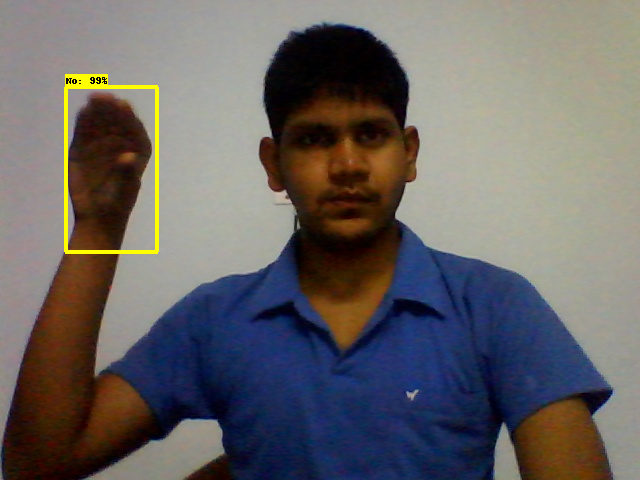

In [ ]:
TEST_IMG_PATH = "/content/Application/workspace/images/test/No_6.jpg"

image = cv2.imread(TEST_IMG_PATH)
image_np = np.array(image)

input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy()  for key, value in detections.items()}
detections["num_detections"] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image = image_np_with_detections,
            boxes = detections['detection_boxes'],
            classes = detections['detection_classes']+label_id_offset,
            scores = detections['detection_scores'],
            category_index = category_index,
            use_normalized_coordinates = True,
            max_boxes_to_draw = 5,
            min_score_thresh = 0.8,
            agnostic_mode = False)

cv2_imshow(image_np_with_detections)
